# Notes

- [mne.io.RawArray.plot](https://mne.tools/stable/generated/mne.io.RawArray.html#mne.io.RawArray.plot)




## Test 1:

```python
window_sizes = [2.0]
overlaps = [0.1]
accuracy ~90%

```



Init Success
Creating RawArray with float64 data, n_channels=1, n_times=94405
    Range : 0 ... 94404 =      0.000 ...   472.020 secs
Ready.
test


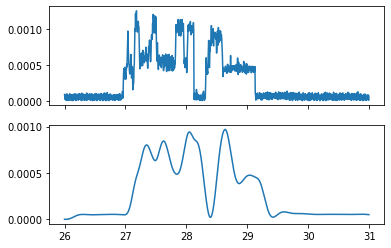

In [1]:
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import copy
import joblib
from PhysioGoDSP import test
from scipy import signal


class PhysioLearn:
    def __init__(self, sessionTitle, num_channels, channel_type, eventMapping=None, eventFile=None, ):
        print()
        self.currentFileDf = []
        self.currentFile = None
        self.channels = num_channels
        self.channelTypes = [channel_type] * num_channels
        self.channelNames = [str(n) for n in range(num_channels)]
        self.sfreq = 200
        self.mneFactor = 1000000 # account for unit conversion if necessary
        self.markerChannel = 14
        self.eventMapping = eventMapping
        
        # Check if this is the best approach
        if eventFile != None:
            self.events = mne.read_events(eventFile)
        else:
            self.events = []
            
        self.date = datetime.now().strftime("%H_%M_%S")
        self.eventsEmbeded = []
        self.raw = None
        self.dataset = []
        self.info = mne.create_info(
            ch_names=self.channelNames, sfreq=self.sfreq, ch_types=self.channelTypes)
        print("Init Success")

    def createEvents(self, filePath):
        i = 0
        array = []
        for sample in self.currentFileDf[self.markerChannel]:
            i = i + 1
            if sample != 0.0:
                array.append([i, 0, int(sample)])
        self.eventsEmbeded = np.array(array, dtype=int)
        df = pd.DataFrame(data=self.eventsEmbeded).to_csv(filePath, sep=" ", index=None, header=None)

        

    def readFile(self, location):
        self.currentFile = DataFilter.read_file(location)
        self.currentFileDf = pd.DataFrame(np.transpose(self.currentFile))
        res = self.currentFile[1:2] / self.mneFactor # only accounts for 1 channel currently
        self.raw = mne.io.RawArray(res, self.info)
        

    def getDataDuration(self):
        #seconds
        return len(self.currentFile[0]) / self.sfreq
         
    def createPlots(self): # what is this doing? 
        duration = round(self.getDataDuration() - 2)
        window_size = duration / 4
        if len(self.eventsEmbeded) == 0:
            events = self.events
        else:
            events = self.eventsEmbeded
        for i in range(4):
            start = i * window_size
            self.raw.plot(events=events, start=start, duration=window_size,
                 event_id=self.eventMapping)
            
    def getEvents(self):
        if len(self.eventsEmbeded) == 0:
            events = self.events
        else:
            events = self.eventsEmbeded
        
        return events
    
    def getWindowBandPower(self, start, duration):
        epoch, times = self.getEpoch(start, duration)
        [avgs, stddevs] = DataFilter.get_avg_band_powers(epoch, [0], self.sfreq, True)
        print(avgs)
        return avgs
    

    def getSignalEnvelope(self, signal):
        y = self.rectify(signal)
        print(y)
        
        
        
    def plotEvents(self, eventDuration):
        events = self.getEvents()
        e_map = {100: 'Rest', 99: 'Lift', 98: 'Squeeze' }
        for event in events:
            data, times = self.getEpoch(int(event[0] / self.sfreq), eventDuration)
            fig, ax = plt.subplots(figsize=(4.5, 3))
            title = e_map[event[2]]
            plt.title(title)
            ax.plot(times, data[0] * self.mneFactor)
            #plt.savefig('raw.png')
            
    def plot(self, title, data, times):
        fig, ax = plt.subplots(figsize=(4.5, 3))
        plt.title(title)
        ax.plot(times, data * self.mneFactor)
        
    def plotBasic(self, title, data, times):
        fig, ax = plt.subplots(figsize=(4.5, 3))
        plt.title(title)
        ax.plot(times, data)
        
            
    def featureExtraction(self, epoch_size, window_sizes, overlaps):
        events = self.getEvents()
        e_map = {100: 'Rest', 99: 'Lift', 98: 'Squeeze' }
        window_sizes = window_sizes
        channels = [0]
        overlaps = overlaps
        dataset_x = list()
        dataset_y = list()
        epochSize = epoch_size
        
        
        for event in events:
            for num, window_size in enumerate(window_sizes):
                    data, times = self.getEpoch(int(event[0] / self.sfreq), epochSize)
                    cur_pos = 0
                    #print(data.shape[1])
                    while cur_pos + int(window_size * self.sfreq) < data.shape[1]:
                        _class = event[2] # last column of event file
                        data_in_window = data[:, cur_pos:cur_pos + int(window_size * self.sfreq)]
                        times_in_window = times[cur_pos:cur_pos + int(window_size * self.sfreq)]
                        #print(data.shape, times.shape)
                        #plotTitle = f'{cur_pos}_{_class}_window({window_size})'
                        #dataCopy = copy.deepcopy(data_in_window[0])
                        #DataFilter.perform_lowpass(data_in_window[0], self.sfreq, 30.0, 1,
                        #          FilterTypes.BUTTERWORTH.value, 1)
                        #self.plot(plotTitle, data_in_window[0], times_in_window)
                        #self.plot(plotTitle+"filtered", dataCopy, times_in_window)
                        
                        # returns 2d array with delta - gamma (bands[0]) 
                        bands = DataFilter.get_avg_band_powers(data_in_window, channels, self.sfreq, True)
                        feature_vector = bands[0]
                        if (event[2] != 99):
                            dataset_x.append(feature_vector)
                            dataset_y.append(e_map[_class])
                        
                        # review overlap to make it more intuitive....
                        cur_pos = cur_pos + int(window_size * overlaps[num] * self.sfreq)
        self.dataset = [dataset_x, dataset_y]
        return self.dataset
                 
    def getEpoch(self, start, eventDuration):
        start = start * self.sfreq
        duration = eventDuration * self.sfreq
        stop = start + duration
        data, times = self.raw.get_data(return_times=True, start=start, stop=stop)
        return data, times
    
    def saveObject(self, model, filename): 
        joblib.dump(model, filename)
        
    def loadObject(self, fileName):
        model = joblib.load(fileName)
        return model
    
    def testLocalModel(self, modelFileName, dataset, test_size=0.33, random_state=1):
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(dataset[0], dataset[1], test_size=test_size, random_state=random_state)
        model = self.loadModel(modelFileName)
        score = model.score(X_test, Y_test)
        x = self.dataset[0]
        predicted = model.predict(x)
        return score
        

    def start(self, fileName):
        self.readFile(fileName)
        #self.createEvents()
        #self.createPlots() 
        #self.plotEvents(4)
        #data, times = self.getEpoch(0, 10)
        #self.getWindowBandPower(0, 5)
        
        # Get Dataset
        #self.dataset = self.prepareData([2.0], [0.1]) # get dataset
        
        # Train Model
        #self.train_knn(self.dataset, 1)
        #self.train_lda(self.dataset)
        #self.train_regression(self.dataset)
        
        # Test model
        #score = self.testLocalModel("models/lda-emg-lift.pkl", self.dataset)
        
        #self.saveObject(self.dataset, "models/squeeze-emg-x-y.dataset")
        
        # Load Model
        #data = self.loadObject("models/lift-emg-x-y.dataset")
     
    
    def rectify(self, signal):
        y = [abs(x) for x in signal]
        return y
        
        
    
    
    ''' Training '''
    def train_knn(self, data, neighbors):
        print('#### KNN ####')
        model = KNeighborsClassifier(n_neighbors=neighbors)
        scores = cross_val_score(model, data[0], data[1], cv=5, scoring='f1_macro', n_jobs=8)
        print('f1 macro %s' % str(scores.mean()))
        scores = cross_val_score(model, data[0], data[1], cv=5, scoring='precision_macro', n_jobs=8)
        print('precision macro %s' % str(scores.mean()))
        scores = cross_val_score(model, data[0], data[1], cv=5, scoring='recall_macro', n_jobs=8)
        print('recall macro %s' % str(scores.mean()))
        
    def train_regression(self, data):
        print('#### Logistic Regression ####')
        model = LogisticRegression(class_weight='balanced', solver='liblinear',
                               max_iter=4000, penalty='l2', random_state=1)
        scores = cross_val_score(model, data[0], data[1], cv=5, scoring='f1_macro', n_jobs=8)
        print('f1 macro %s' % str(scores.mean()))
        scores = cross_val_score(model, data[0], data[1], cv=5, scoring='precision_macro', n_jobs=8)
        print('precision macro %s' % str(scores.mean()))
        scores = cross_val_score(model, data[0], data[1], cv=5, scoring='recall_macro', n_jobs=8)
        print('recall macro %s' % str(scores.mean()))
        
    
    def train_lda(self, data):
        model = LinearDiscriminantAnalysis()
        print('#### Linear Discriminant Analysis ####')
        scores = cross_val_score(model, data[0], data[1], cv=5, scoring='f1_macro', n_jobs=8)
        print('f1 macro %s' % str(scores.mean()))
        scores = cross_val_score(model, data[0], data[1], cv=5, scoring='precision_macro', n_jobs=8)
        print('precision macro %s' % str(scores.mean()))
        scores = cross_val_score(model, data[0], data[1], cv=5, scoring='recall_macro', n_jobs=8)
        print('recall macro %s' % str(scores.mean()))
        model.fit(data[0], data[1])
        #self.saveObject(model, "models/lda-emg-lift.pkl")
        
        
def main():  
    event_mapping = {'Rest': 100, 'Lift': 99, 'Squeeze': 98}
    #learn = PhysioLearn(1, "emg", event_mapping, "data/events-gen-cleaned-eve.txt")
    learn = PhysioLearn("Crawford_EMG_Model", 1, "emg", event_mapping)
    learn.readFile("data/crawford_EMG_Test.csv")
    learn.createEvents("data/crawford_events2.txt")
    #learn.plotEvents(2)
    dataset = learn.featureExtraction(4, [2.0], [0.4])
    print(learn.dataset)
    
    # Train Model
    #print(dataset[0])
    #learn.train_knn(dataset, 2)
    #learn.train_lda(dataset)
    #learn.train_regression(dataset)
        

def rectification():
    event_mapping = {'Rest': 100, 'Lift': 99, 'Squeeze': 98}
    learn = PhysioLearn("Crawford_EMG_Model", 1, "emg", event_mapping)
    learn.readFile("data/crawford_EMG_Test.csv")
    learn.createEvents("data/crawford_events2.txt")
    
    #Get Events
    events = learn.getEvents()
    
    ## Plot all
    '''
    for x, event in enumerate(events):
        start = int(events[x][0]/200)
        data, times = learn.getEpoch(start, 5)
        y = learn.rectify(data[0])
        
        #rectification (full-wave)
        #data2 = [abs(x) for x in data[0]]
        
        learn.plotBasic(str(event[2]), y, times)  
    '''
    event = 4
    start = int(events[event][0]/200)
    data, times = learn.getEpoch(start, 5)
    fs = 200
    y = learn.rectify(data[0])
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.plot(times, y)
    
    #filter
    sos = signal.butter(4, 3, 'lowpass', fs=200, output='sos')
    filtered = signal.sosfilt(sos, y)
    ax2.plot(times, filtered)
    test()
        
    '''
    analytic_signal = hilbert(data[0])
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * fs)
    '''
    
    #ax1.plot(t[1:], instantaneous_frequency)
    
    #print(analytic_signal)
    '''
    learn.plotBasic(f'Raw {event}', data[0], times)  
    learn.plotBasic(f'analytic_signal {event}', analytic_signal, times)
    learn.plotBasic(f'rectified signal {event}', y, times)
    learn.plotBasic(f'instantaneous_frequency {event}', instantaneous_frequency, times[1:])
    '''
    #learn.getSignalEnvelope()
    
    
    
    
    
    
#main()
rectification()


